In [9]:
import matplotlib.pyplot as plt

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())

train_idx = mnist_train.train_labels <= 1
mnist_train.data = mnist_train.train_data[train_idx]
mnist_train.targets = mnist_train.train_labels[train_idx]

test_idx = mnist_test.test_labels <= 1
mnist_test.data = mnist_test.test_data[test_idx]
mnist_test.targets = mnist_test.test_labels[test_idx]

train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

# do a single pass over the data
def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model(X.view(X.shape[0], -1))[:,0]
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [6]:
model = nn.Linear(784, 1)
opt = optim.SGD(model.parameters(), lr=1.)
print("Train Err", "Train Loss", "Test Err", "Test Loss", sep="\t")
for i in range(10):
    train_err, train_loss = epoch(train_loader, model, opt)
    test_err, test_loss = epoch(test_loader, model)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Train Err	Train Loss	Test Err	Test Loss
0.004422	0.014996	0.000473	0.003453
0.001184	0.005321	0.000473	0.002685
0.001184	0.004514	0.000473	0.002344
0.000947	0.003909	0.000473	0.002143
0.001026	0.003554	0.000473	0.002105
0.001026	0.003256	0.000473	0.001990
0.000947	0.003053	0.000473	0.001943
0.000869	0.002825	0.000473	0.001931
0.000790	0.002686	0.000473	0.001862
0.000711	0.002507	0.000946	0.001879


/Users/skrishna/opt/anaconda3/lib/python3.9/site-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/Users/skrishna/opt/anaconda3/lib/python3.9/site-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


ValueError: only one element tensors can be converted to Python scalars

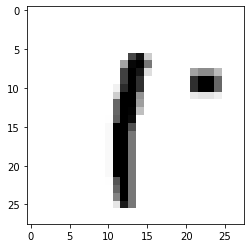

In [10]:
X_test = (test_loader.dataset.test_data.float()/255).view(len(test_loader.dataset),-1)
y_test = test_loader.dataset.test_labels
yp = model(X_test)[:,0]
idx = (yp > 0) * (y_test == 0) + (yp < 0) * (y_test == 1)
plt.imshow(1-X_test[idx][0].view(28,28).numpy(), cmap="gray")
plt.title("True Label: {}".format(y_test[idx].item()))

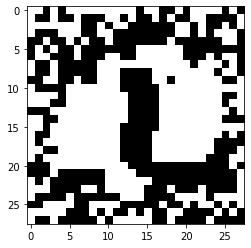

In [11]:
epsilon = 0.2
delta = epsilon * model.weight.detach().sign().view(28,28)
plt.imshow(1-delta.numpy(), cmap="gray")

In [12]:
delta.shape

torch.Size([28, 28])

In [18]:
def epoch_adv(loader, model, delta):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        tmp = (2*y.float()[:,None,None,None]-1)
        print(X.shape, y.shape, tmp.shape)
        yp = model((X-(2*y.float()[:,None,None,None]-1)*delta).view(X.shape[0], -1))[:,0]
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)
print(epoch_adv(test_loader, model, delta[None,None,:,:]))

torch.Size([100, 1, 28, 28]) torch.Size([100]) torch.Size([100, 1, 1, 1])
torch.Size([100, 1, 28, 28]) torch.Size([100]) torch.Size([100, 1, 1, 1])
torch.Size([100, 1, 28, 28]) torch.Size([100]) torch.Size([100, 1, 1, 1])
torch.Size([100, 1, 28, 28]) torch.Size([100]) torch.Size([100, 1, 1, 1])
torch.Size([100, 1, 28, 28]) torch.Size([100]) torch.Size([100, 1, 1, 1])
torch.Size([100, 1, 28, 28]) torch.Size([100]) torch.Size([100, 1, 1, 1])
torch.Size([100, 1, 28, 28]) torch.Size([100]) torch.Size([100, 1, 1, 1])
torch.Size([100, 1, 28, 28]) torch.Size([100]) torch.Size([100, 1, 1, 1])
torch.Size([100, 1, 28, 28]) torch.Size([100]) torch.Size([100, 1, 1, 1])
torch.Size([100, 1, 28, 28]) torch.Size([100]) torch.Size([100, 1, 1, 1])
torch.Size([100, 1, 28, 28]) torch.Size([100]) torch.Size([100, 1, 1, 1])
torch.Size([100, 1, 28, 28]) torch.Size([100]) torch.Size([100, 1, 1, 1])
torch.Size([100, 1, 28, 28]) torch.Size([100]) torch.Size([100, 1, 1, 1])
torch.Size([100, 1, 28, 28]) torch.Siz

In [14]:
# do a single pass over the data
def epoch_robust(loader, model, epsilon, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model(X.view(X.shape[0], -1))[:,0] - epsilon*(2*y.float()-1)*model.weight.norm(1)
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [15]:
model = nn.Linear(784, 1)
opt = optim.SGD(model.parameters(), lr=1e-1)
epsilon = 0.2
print("Rob. Train Err", "Rob. Train Loss", "Rob. Test Err", "Rob. Test Loss", sep="\t")
for i in range(20):
    train_err, train_loss = epoch_robust(train_loader, model, epsilon, opt)
    test_err, test_loss = epoch_robust(test_loader, model, epsilon)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Rob. Train Err	Rob. Train Loss	Rob. Test Err	Rob. Test Loss
0.152783	0.381261	0.064303	0.209316
0.073431	0.223573	0.057683	0.182352
0.063877	0.197828	0.043026	0.154724
0.057560	0.183956	0.044444	0.161882
0.053849	0.175002	0.038298	0.136786
0.049270	0.167923	0.036879	0.132805
0.047690	0.162962	0.033570	0.123982
0.046269	0.158581	0.031678	0.121913
0.044374	0.154732	0.029787	0.115812
0.042953	0.151800	0.026005	0.111248
0.041769	0.149208	0.027423	0.112844
0.040426	0.147004	0.028369	0.116637
0.039558	0.145121	0.027423	0.112877
0.038768	0.143373	0.027896	0.111257
0.037900	0.141694	0.026950	0.107551
0.036952	0.140437	0.027423	0.111476
0.036242	0.139278	0.025532	0.104039
0.035689	0.138043	0.025059	0.101814
0.035057	0.137226	0.024586	0.102390
0.034268	0.136248	0.023641	0.098232
